# Benchmark structural regression 

In [198]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [204]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"

In [200]:
dataset = "homfam"

In [324]:
### parse trace files
def get_computation_times(evaluation_dir, dataset, task):
    # Extract trace files w/ corresponding alignments
    traces = pd.DataFrame()
    alignments_dir = join(evaluation_dir,task)
    for fam in listdir(alignments_dir):
        family_dir=join(alignments_dir, fam)
        # For each family
        for f in listdir(family_dir):
            # Extract trace file 
            if(os.path.isdir(join(family_dir,f))): 
                # parse trace
                name_trace = ".command.trace"
                trace = join(join(family_dir,f), name_trace)
                df = pd.read_csv(trace, sep = "=").T
                df = df.rename(index={'nextflow.trace/v2': f})
                traces = traces.append(df)

    # Trace files parsed
    traces = traces.reset_index(level=0)
    traces = traces.rename(columns={'index': 'name'})
    traces["benchmarking_dataset"] = dataset
    return(traces)

In [325]:
def add_families(trees_traces):
    trees_traces["family"] = trees_traces.name.str.split(".",expand=True)[0]
    trees_traces["tree_method"] = trees_traces.name.str.split(".",expand=True)[1]
    return(trees_traces)

#### Load datasets informations (Homfam + extHomfam)

In [352]:
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})
summary_homfam_exthomfam.head(2)

,family,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,benchmarking_dataset
0,rvp,combined,93681,94.288554,22,133,rvp,xlarge,0.006405,homfam
1,zf-CCHH,combined,88345,23.251265,12,35,zf-CCHH,xlarge,0.016979,homfam


# <div style="text-align: center;"> <span align="center" style="color:blue">_________TREES_________</span> </div>


In [488]:
trees_traces_homfam = get_computation_times(join(evaluation_dir, "homfam"), "homfam", "trees")
trees_traces_homfam = add_families(trees_traces_homfam)

trees_traces_exthomfam_v35 = get_computation_times(join(evaluation_dir, "extHomfam_v35-uniprot"), "extHomfam_v35-uniprot", "trees")
trees_traces_exthomfam_v35 = add_families(trees_traces_exthomfam_v35)

trees_traces = pd.concat([trees_traces_homfam, trees_traces_exthomfam_v35])

stat_trees = pd.merge(trees_traces, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
stat_trees.head(2)

,name,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,...,family,tree_method,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
0,il8.FAMSA-parttree,81,600,138715,30817,142,22,1024000,32768,0,...,il8,FAMSA-parttree,combined,1073,63.762349,18,82,il8,small,1.025163
1,il8.FAMSA-medoid,379,829,138725,30822,142,22,1024000,32768,0,...,il8,FAMSA-medoid,combined,1073,63.762349,18,82,il8,small,1.025163


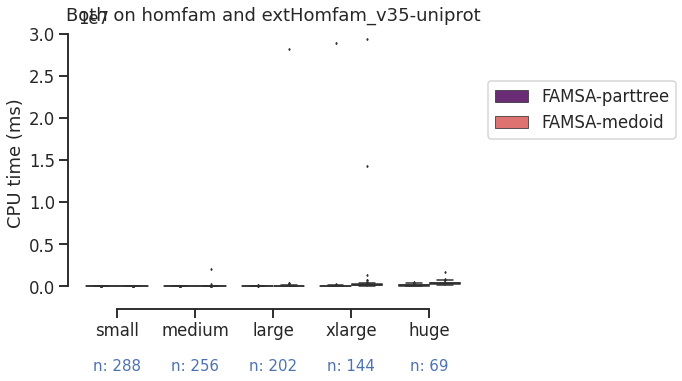

In [495]:

sns.set_theme(style="ticks")
sns.set_context("talk")

# Load the example tips dataset
f, ax = plt.subplots(figsize=(7, 5))
df = stat_trees
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="size_group", y="realtime",
            hue="tree_method", palette = "magma",
            data=df, linewidth=1.5, fliersize = 1.5, dodge = True)

# Calculate number of obs per group & median to position labels
nobs = df['size_group'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            -10050000,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='b')
 


ax.set(ylabel='CPU time (ms)', xlabel='', title = "Both on homfam and extHomfam_v35-uniprot")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)

sns.despine(offset=10, trim=True)
#f, ax = plt.subplots(figsize=(7, 7))
#sns.scatterplot(data=stat_trees, y="realtime", x="n_sequences", hue="tree_method",
#                palette = "magma",style = "benchmarking_dataset", s = 30)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#ax.set(ylabel='CPU time (ms)', xlabel='number of sequences')

### EVALUATION scores 

In [177]:
def get_evaluation(evaluation_dir, dataset):
    scores = evaluation_dir + "/CSV/dynamic.scores.csv"
    scores_df = pd.read_csv(scores, sep=";", header = None).iloc[: , :-1]
    scores_df.set_axis(list(["name", "sp","tc", "column"]), axis=1, inplace=True)
    scores_df[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val",
               "master_msa", "master_batch",
               "slave_msa", "slave_batch","tree"]] = scores_df.name.str.split(".", expand = True)
    scores_df["benchmarking_dataset"] = dataset
    return(scores_df)

In [179]:
scores_df_homfam = get_evaluation(join(evaluation_dir,dataset), dataset)

In [181]:
## TODO -- add exthomfam
scores_df = scores_df_homfam

### COMPUTATION time

In [209]:
traces_homfam = get_computation_times(join(evaluation_dir, "homfam"), "homfam", "alignments")

FileNotFoundError: [Errno 2] No such file or directory: '/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/alignments'

In [ ]:
traces = traces_homfam

## Merge stats

In [168]:
stats = pd.merge(scores_df, traces, on = "name")

In [170]:
stats = pd.merge(stats, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])

In [173]:
stats.head()

,name,sp,tc,column,family,method,bucket_size,dynamicX_label,dynamicX_val,master_msa,...,inv_ctxt,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,dataset
0,hip.dynamic.100.dynamicX.100000.tcoffee_msa.10...,80.1,50.0,61.5,hip,dynamic,100,dynamicX,100000,tcoffee_msa,...,4487,combined,167,66.209581,54,85,hip,small,2.994012,homfam
1,hip.dynamic.100.dynamicX.100000.tcoffee_msa.10...,80.1,50.0,61.5,hip,dynamic,100,dynamicX,100000,tcoffee_msa,...,4487,combined,627,63.488038,42,85,hip,small,0.797448,exthomfam
2,seatoxin.dynamic.100.dynamicX.100000.tcoffee_m...,70.8,26.5,25.7,seatoxin,dynamic,100,dynamicX,100000,tcoffee_msa,...,1416,combined,93,43.634409,34,50,seatoxin,small,5.376344,homfam


## Visualization 